# LSST SSP Daily Data Products Prototype Pipeline

This is the prototype code that takes _all_ observations of asteroids in LSST (the DIASources, expecting \~1Bn after 10yrs), computes additional quantities (another 1Bn rows; SSSources), and summarized per-object quantities (~10M rows; SSObjects).

It needs to run on a daily basis, and finish in ~1hr (final operational version).

Design principles:
* Design for code readability and speed.
* Always use vectorized ops (for loops are evil in Python).
* Utilize the available hardware (SSDs, large RAM machine), and design a solution that takes advantage of it if it results in a simpler code

Design:
* Represent tables as numpy structured arrays, maximally use vectorized ndarray ops.
* Mmap the arrays from disk files. Place these onto our NVME.
* Parallelize w. multiprocessing, by starting multiprocessing _after_ having mmapped the files. As child processes inherit open file descriptors, the mmapped files become writable by all of them (and there’s no need to exchange info via queues).
* Use pg_bulkload postgres extension to directly read these binary files and ingest them quickly into postgres.

Currently this notebook uses a few hardcoded paths on epyc.astro.washington.edu, and won't run elsewhere unless modified.

In [1]:
# add pymoid path
import sys
sys.path.append("/astro/users/mjuric" + "/projects/github.com/dirac-institute/pymoid")

In [2]:
import pandas as pd
import numpy as np
import astropy, astropy.coordinates
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

## A look at the inputs

Assuming the inputs are in a bunch of Pandas-written HDF5 files (outputs of postprocessing by Cornwall et al.'s pipeline)

In [3]:
det = pd.read_hdf('detections/S0/visit-0000000.h5').reset_index()
det

,index,ObjID,FieldID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),Ast-Sun(J2000y)(km),Ast-Sun(J2000z)(km),Ast-Sun(J2000vx)(km/s),Ast-Sun(J2000vy)(km/s),Ast-Sun(J2000vz)(km/s),Obs-Sun(J2000x)(km),Obs-Sun(J2000y)(km),Obs-Sun(J2000z)(km),Obs-Sun(J2000vx)(km/s),Obs-Sun(J2000vy)(km/s),Obs-Sun(J2000vz)(km/s),Sun-Ast-Obs(deg),V,V(H=0),MaginFilterTrue,AstrometricSigma(mas),PhotometricSigma(mag),SNR,AstrometricSigma(deg),MaginFilter,dmagDetect,AstRATrue(deg),AstDecTrue(deg),filter
0,116,S0000n9Xa,9005,59865.226645,4.451975e+07,12.528467,1.567094,-0.095213,-38.402546,0.119151,1.755471e+08,4.679075e+07,-7.790515e+06,-0.160202,25.603220,4.174276,1.406715e+08,4.583665e+07,1.986437e+07,-10.658388,25.986230,11.116827,37.965823,22.913031,-0.682969,22.458031,36.795455,0.082748,12.627359,0.000010,22.477508,0.015700,1.567076,-38.402538,i
1,362,S000002Ka,1100,59855.096368,1.188922e+08,32.148949,323.038235,0.327594,2.563636,-0.306363,2.425427e+08,-4.861209e+07,1.520061e+07,25.379694,13.984888,5.726029,1.476385e+08,2.280410e+07,9.882683e+06,-5.274512,27.212151,11.637944,25.609063,17.603077,1.769077,17.300077,10.183976,0.004197,258.178230,0.000003,17.294223,0.118743,323.038236,2.563637,y
2,449,S000003ra,1987,59856.994198,1.908938e+08,-3.370815,298.450449,-0.053454,31.572576,-0.685623,2.241459e+08,-1.158051e+08,1.117330e+08,-2.365411,16.400955,-12.725323,1.466658e+08,2.719036e+07,1.178524e+07,-6.047887,26.883704,11.564641,31.117344,19.303783,3.190783,18.897783,21.523548,0.027653,38.764632,0.000006,18.917968,0.131007,298.450457,31.572577,y
3,508,S000003Ma,8045,59864.160584,4.088149e+08,20.819305,348.302035,-0.208466,-16.221058,-0.034934,5.259977e+08,-3.612397e+07,-9.536294e+07,5.455896,6.130693,2.600942,1.416104e+08,4.346468e+07,1.883721e+07,-9.979056,26.207076,11.186591,9.631008,21.814421,5.585421,21.413421,28.452016,0.056634,18.675421,0.000008,21.347133,0.026645,348.302024,-16.221079,z
4,858,S000007fa,7727,59864.000376,3.004865e+08,21.559342,321.788645,-0.029926,4.309341,-0.139713,3.771804e+08,-1.422424e+08,4.126130e+07,6.733808,10.973905,4.359714,1.417454e+08,4.310231e+07,1.868230e+07,-9.538974,26.088663,11.196027,17.546223,21.633325,4.598325,21.378325,18.216054,0.024298,44.185822,0.000005,21.394567,0.007612,321.788641,4.309353,r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6448,10029,S0000745a,7882,59864.079765,6.912083e+07,7.094495,352.873167,-0.653118,-40.060490,0.796790,1.941732e+08,3.671822e+07,-2.572683e+07,1.888309,17.706726,15.140694,1.416793e+08,4.328167e+07,1.875908e+07,-9.738682,26.194033,11.191320,36.334351,22.548590,0.425590,22.093590,40.622567,0.074980,13.986195,0.000011,22.137017,0.345272,352.873153,-40.060516,i
6449,10402,S0000sPHa,1506,59856.171339,1.678122e+07,10.732486,331.703498,2.113169,-27.924804,1.437663,1.601639e+08,1.826734e+07,3.102950e+06,7.353113,27.153486,10.878854,1.471084e+08,2.529597e+07,1.096180e+07,-6.006779,27.156575,11.598546,44.245081,20.979868,-2.888132,20.573868,28.806784,0.053006,19.987176,0.000008,20.604182,1.036562,331.703512,-27.924807,y
6450,10403,S0000sPHa,1539,59856.186517,1.679531e+07,10.765808,331.735607,2.116364,-27.902964,1.440287,1.601736e+08,1.830294e+07,3.117216e+06,7.346462,27.152727,10.878725,1.471005e+08,2.533158e+07,1.097701e+07,-6.052625,27.151039,11.598039,44.221561,20.981224,-2.886776,20.575224,20.377370,0.044074,24.137854,0.000006,20.576101,1.240693,331.735609,-27.902966,y
6451,10552,S0000u8Ua,8664,59865.060614,5.213458e+07,35.507359,323.779396,0.517643,1.412867,0.525480,1.828676e+08,1.466629e+07,2.099028e+07,21.573060,9.532312,17.537070,1.408210e+08,4.546306e+07,1.970483e+07,-10.176497,26.028662,11.127109,41.010099,23.700930,-0.222070,23.445930,69.575240,0.119664,8.582386,0.000019,23.422910,0.212583,323.779359,1.412856,r


Datatypes check:

In [4]:
det.dtypes

index                       int64
ObjID                      object
FieldID                     int64
FieldMJD                  float64
AstRange(km)              float64
AstRangeRate(km/s)        float64
AstRA(deg)                float64
AstRARate(deg/day)        float64
AstDec(deg)               float64
AstDecRate(deg/day)       float64
Ast-Sun(J2000x)(km)       float64
Ast-Sun(J2000y)(km)       float64
Ast-Sun(J2000z)(km)       float64
Ast-Sun(J2000vx)(km/s)    float64
Ast-Sun(J2000vy)(km/s)    float64
Ast-Sun(J2000vz)(km/s)    float64
Obs-Sun(J2000x)(km)       float64
Obs-Sun(J2000y)(km)       float64
Obs-Sun(J2000z)(km)       float64
Obs-Sun(J2000vx)(km/s)    float64
Obs-Sun(J2000vy)(km/s)    float64
Obs-Sun(J2000vz)(km/s)    float64
Sun-Ast-Obs(deg)          float64
V                         float64
V(H=0)                    float64
MaginFilterTrue           float64
AstrometricSigma(mas)     float64
PhotometricSigma(mag)     float64
SNR                       float64
AstrometricSig

Check astrometric errors:

Text(0.5, 0, 'Separation (arcsec)')

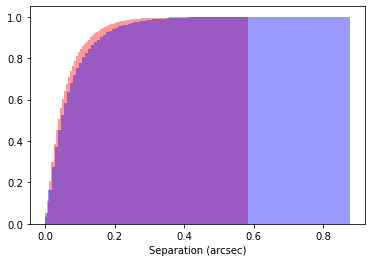

In [5]:
# from the file
obs = astropy.coordinates.SkyCoord(ra=det["AstRA(deg)"].values, dec=det["AstDec(deg)"].values, unit="deg")
tru = astropy.coordinates.SkyCoord(ra=det["AstRATrue(deg)"].values, dec=det["AstDecTrue(deg)"].values, unit="deg")
sep = obs.separation(tru)

# manually recompute
import numpy as np
err1d = 1./np.sqrt(2) * det["AstrometricSigma(deg)"]
newDec = np.random.normal(loc=det["AstDecTrue(deg)"], scale=err1d)
newRa = np.random.normal(loc=det["AstRATrue(deg)"], scale=err1d / np.cos(np.deg2rad(det["AstDecTrue(deg)"])))
newRa = np.fmod(newRa + 360, 360)
new = astropy.coordinates.SkyCoord(ra=newRa, dec=newDec, unit="deg")
old = astropy.coordinates.SkyCoord(ra=det["AstRA(deg)"].values, dec=det["AstDec(deg)"].values, unit="deg")
sep2 = new.separation(old)

# plot
plt.hist(sep.arcsec, bins=100, cumulative=True, density=True, alpha=0.4, color='red');   # from the file
plt.hist(sep2.arcsec, bins=100, cumulative=True, density=True, alpha=0.4, color='blue'); # manually computed
plt.xlabel("Separation (arcsec)")

## Create the DIASource Table

In [329]:
# A simple hashing function to convert names to 64bit IDs. 
# We'll use this to generate various primary key IDs from asteroid designations
import hashlib
def hashTo64(s):
    if not isinstance(s, str):
        s = str(s)
    return np.uint64(int.from_bytes(hashlib.sha224(s.encode("utf-8")).digest()[-8:], "little"))
hashTo64("foo"), hashTo64(12)

(15850672484136054362, 17586167158575412398)

In [111]:
# Let's make sure that the probability of hash collision is low
# ( using the usual p(collision) = n^2/(2*H) approximation)
14_000_000**2/(2*2**63)

1.0625181290357943e-05

In [8]:
# A function that takes the postprocessed input (as a DataFrame), and returns a dataframe with DIASource schema
#
def convertToDiaSource(det, validate=False):
    # create unique diaSourceId's by concatenating FieldID, ObjID and then hashing
    diaSourceId = (det["FieldID"].astype(str) + det["ObjID"]).apply(hashTo64).astype('uint64')
    assert np.all(diaSourceId.unique() == diaSourceId)
    df = pd.DataFrame({"diaSourceId": diaSourceId})

    # FIXME: ccdVisitId should be a combination of the CCD where the source was and the visitId
    #        see https://github.com/lsst/sdm_schemas/blob/master/sql/baselineSchema.sql#L2924
    # The postprocessor should output which CCD the object is on
    df["ccdVisitId"] = det["FieldID"].astype('uint32')

    # diaObjectId -- we'll this should be unique for all these, as we'll assume the detections won't overlap
    #   with any other detection thus not creating joint DiaObject. 
    # FIXME: The above won't be true -- an asteroid could come over a star or another asteroid. We need to
    #        figure this out for more precise sims later.
    df["diaObjectId"] = diaSourceId.apply(hashTo64).astype('uint64')
    if validate:
       assert np.all(df["diaObjectId"].unique() == df["diaObjectId"])

    # ssObjectId -- we'll create a unique 64bit int by just hashing the input ObjID
    df["ssObjectId"] = det["ObjID"].apply(hashTo64).astype('uint64')
    df["_name"] = det["ObjID"]
    if validate:
        # verify this generated unique IDs by grouping by the diaObjectId and checking each group has only one unique ObjID
        tmp = df[["ssObjectId"]].copy()
        tmp["ObjID"] = det["ObjID"]
        assert np.all(tmp.groupby("ssObjectId").agg(lambda x: len(np.unique(x))) == 1)
        del tmp

    # parentDiaSourceId, prv_procOrder
    ##df["parentDiaSourceId"] = np.nan
    ##df["prv_procOrder"] = np.nan

    # Assume everything is discovered immediately
    # FIXME: improve when we start doing actual linking, this will then be the time when we linked
    #        the object for the first detection, and then immediate once object is attributable in
    #        real time
    df["ssObjectReassocTime"] = det["FieldMJD"]

    # astrometry.
    # FIXME: We're assuming the astrometry has no covariance, while in reality it will. We could
    # at least have it be orhogonal in the row,col direction on the CCD.
    df["midPointTai"] = det["FieldMJD"]
    df["ra"] = det["AstRA(deg)"]
    df["raSigma"] = (1./np.sqrt(2) * det["AstrometricSigma(deg)"]).astype('float32')
    df["decl"] = det["AstDec(deg)"]
    df["declSigma"] = (1./np.sqrt(2) * det["AstrometricSigma(deg)"]).astype('float32')
    df["ra_decl_Cov"] = np.float32(0.)

    # CCD location
    # FIXME: compute this
    ##df["x"] = df["y"] = np.nan
    ##df["xSigma"] = df["ySigma"] = df["x_y_Cov"] = np.nan

    # SNR
    df["snr"] = det["SNR"].astype('float32')

    # Fields that aren't in the official schema (but should be, IMHO)
    df["filter"] = det["filter"]
    df["mag"] = det["MaginFilter"].astype('float32')
    df["magSigma"] = det["PhotometricSigma(mag)"].astype('float32')

    # Truth values
    df["_V"] = det["V"].astype('float32')
    df["_magTrue"] = det["MaginFilterTrue"].astype('float32')
    df["_raTrue"] = det["AstRATrue(deg)"]
    df["_decTrue"] = det["AstDecTrue(deg)"]

    return df

# display
df = convertToDiaSource(det, validate=True)
print(df.dtypes)

# array conversions and checks
arr = np.asarray(df.to_records(index=False, column_dtypes={"filter": "S1", "_name": "S16"}))
#print(arr.dtype.fields)
for colname, (t, _) in arr.dtype.fields.items():
    assert t != np.dtype('O'), f"'{colname}'' is an object type; add it to column_dtypes"

diaSourceId             uint64
ccdVisitId              uint32
diaObjectId             uint64
ssObjectId              uint64
_name                   object
ssObjectReassocTime    float64
midPointTai            float64
ra                     float64
raSigma                float32
decl                   float64
declSigma              float32
ra_decl_Cov            float32
snr                    float32
filter                  object
mag                    float32
magSigma               float32
_V                     float32
_magTrue               float32
_raTrue                float64
_decTrue               float64
dtype: object


In [9]:
df

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,_name,ssObjectReassocTime,midPointTai,ra,raSigma,decl,declSigma,ra_decl_Cov,snr,filter,mag,magSigma,_V,_magTrue,_raTrue,_decTrue
0,13686319375064291250,9005,8927705041255612141,10485932001797203160,S0000n9Xa,59865.226645,59865.226645,1.567094,0.000007,-38.402546,0.000007,0.0,12.627358,i,22.477509,0.082748,22.913031,22.458031,1.567076,-38.402538
1,12773750898095995968,1100,11490660269159883385,7023531818364903932,S000002Ka,59855.096368,59855.096368,323.038235,0.000002,2.563636,0.000002,0.0,258.178223,y,17.294222,0.004197,17.603077,17.300077,323.038236,2.563637
2,460158244297883768,1987,2284803406784230904,7978460588232203911,S000003ra,59856.994198,59856.994198,298.450449,0.000004,31.572576,0.000004,0.0,38.764633,y,18.917967,0.027653,19.303783,18.897783,298.450457,31.572577
3,10148019411412753813,8045,5464635500780163017,287337001356706064,S000003Ma,59864.160584,59864.160584,348.302035,0.000006,-16.221058,0.000006,0.0,18.675421,z,21.347134,0.056634,21.814421,21.413422,348.302024,-16.221079
4,1357153141352090269,7727,6345775201006937966,14735910076348708391,S000007fa,59864.000376,59864.000376,321.788645,0.000004,4.309341,0.000004,0.0,44.185822,r,21.394567,0.024298,21.633324,21.378325,321.788641,4.309353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6448,967094901830348058,7882,2592401039816121026,7564379516452213843,S0000745a,59864.079765,59864.079765,352.873167,0.000008,-40.060490,0.000008,0.0,13.986195,i,22.137016,0.074980,22.548590,22.093590,352.873153,-40.060516
6449,7287486568141753446,1506,14215091468888016634,14757010473516078372,S0000sPHa,59856.171339,59856.171339,331.703498,0.000006,-27.924804,0.000006,0.0,19.987177,y,20.604181,0.053006,20.979868,20.573868,331.703512,-27.924807
6450,8195327888804454972,1539,18425227390610935985,14757010473516078372,S0000sPHa,59856.186517,59856.186517,331.735607,0.000004,-27.902964,0.000004,0.0,24.137854,y,20.576101,0.044074,20.981224,20.575224,331.735609,-27.902966
6451,5930712588545755894,8664,13250215212659672519,3134105698373045211,S0000u8Ua,59865.060614,59865.060614,323.779396,0.000014,1.412867,0.000014,0.0,8.582386,r,23.422911,0.119664,23.700930,23.445930,323.779359,1.412856


## Create a single, huge, mmapped array for the DIASource table

The strategy:
* Find out how many DIASources we'll have, by scanning all input files
* Create huge mmapped array with the DIASource schema, and the expected number of rows
* Iterate (in parallel) through all input files, converting each one of them into the DIASource schema, and then writing them out into the right place of the big mmapped array

In [10]:
# all input files
import glob
detFiles = glob.glob("det/S*/visit-*.h5")

In [11]:
def scanInputs(inputs):
    import tables
    from tqdm.notebook import tqdm

    ret = {}
    for fn in tqdm(inputs):
        with tables.open_file(fn) as fp:
            try:
                ret[fn] = fp.root.data.table.shape[0]
            except tables.NoSuchNodeError:
                # empty file
                pass

    # convert to dataframe with sizes and offsets
    df = pd.DataFrame(ret.items(), columns=["filename", "size"])
    df["offset"] = df["size"].cumsum() - df["size"]
    assert df.iloc[-1]["offset"] + df.iloc[-1]["size"] == df["size"].sum()
    
    return df

inputs = scanInputs(detFiles)
nrows = sum(inputs['size'])
print(f"Total observations: {nrows}")

  0%|          | 0/3690 [00:00<?, ?it/s]

Total observations: 1043415800


The file names of memory-mapped arrays, and aux functions to open/create them.

In [12]:
diaFn = "outputs/diaSource.npy"
sssFn = "outputs/ssSource.npy"
objFn = "outputs/ssObject.npy"
mpcFn = "outputs/mpcorb.npy"

In [14]:
import mmap, os
MAP_POPULATE = 0x08000
MAP_LOCKED = 0x2000

def openOrCreateArray(dbfn, nrows, dtype, clobber=False):
    if clobber:
        try:
            os.unlink(dbfn)
        except FileNotFoundError:
            pass

#    ! dd if=/dev/zero of={dbfn} bs=1M count={int((nrows*arr.dtype.itemsize)/(1024*1024))} conv=fdatasync,notrunc status=progress oflag=direct
    if os.path.exists(dbfn):
        # if the file exists, the size must match the expectation
        assert nrows*dtype.itemsize == os.path.getsize(dbfn)
        print(f"Opening existing file {dbfn}")

    fp = os.open(dbfn, os.O_RDWR | os.O_CREAT)# | os.O_DIRECT)
    os.ftruncate(fp, nrows*dtype.itemsize)
    mm = mmap.mmap(fp, 0, flags=mmap.MAP_SHARED | MAP_POPULATE)
    arr = np.ndarray(shape=(nrows,), dtype=dtype, buffer=mm)
    
    return arr, mm, fp

def closeArray(mm_obj, fp):
    import os
    mm_obj.close()
    os.close(fp)

We'll create the SSSource table at the same time, as many of the fields in it are already present in the input data which we're about to read. Define the schema first.

In [13]:
ssSourceDtype = np.dtype([
    ('ssObjectId', 'u8'),
    ('diaSourceId', 'u8'),
    ('mpcUniqueId', 'u8'),
    ('eclipticLambda', 'f8'),
    ('eclipticBeta', 'f8'),
    ('galacticL', 'f8'),
    ('galacticB', 'f8'),
    ('phaseAngle', 'f4'),
    ('heliocentricDist', 'f8'),
    ('topocentricDist', 'f8'),
    ('predictedMagnitude', 'f4'),
    ('predictedMagnitudeSigma', 'f4'),
    ('residualRa', 'f4'),
    ('residualDec', 'f4'),
    ('predictedRaSigma', 'f4'),
    ('predictedDecSigma', 'f4'),
    ('predictedRaDecCov', 'f4'),
    ('heliocentricX', 'f8'),
    ('heliocentricY', 'f8'),
    ('heliocentricZ', 'f8'),
    ('heliocentricVX', 'f8'),
    ('heliocentricVY', 'f8'),
    ('heliocentricVZ', 'f8'),
    ('topocentricX', 'f8'),
    ('topocentricY', 'f8'),
    ('topocentricZ', 'f8'),
    ('topocentricVX', 'f8'),
    ('topocentricVY', 'f8'),
    ('topocentricVZ', 'f8')
])
ssSourceDtype.itemsize, arr.itemsize

(200, 125)

Now create the memory mapped arrays which we'll write into. These are intentionally in global variables, so when multiprocessing forks the worker processes they will automatically inherit the open memory mapping.

In [15]:
dia, dia_mm, dia_fp = openOrCreateArray(diaFn, nrows, arr.dtype)

Opening existing file outputs/diaSource.npy


In [16]:
sss, sss_mm, sss_fp = openOrCreateArray(sssFn, nrows, ssSourceDtype)

Opening existing file outputs/ssSource.npy


In [17]:
! ls -lh outputs/*.npy

-rwxrwxr-x 1 mjuric mjuric 122G Jun 21 00:04 outputs/diaSource.npy
-rwxrwxr-x 1 mjuric mjuric 2.7G Jun 20 23:43 outputs/mpcorb.npy
-rwxrwxr-x 1 mjuric mjuric 2.4G Jun 20 23:50 outputs/ssObject.npy
-rwxrwxr-x 1 mjuric mjuric 195G Jun 21 00:04 outputs/ssSource.npy


Iterate through all files and populate the memory-mapped array for the DIASource and SSSource tables.

In [39]:
def _createDiaSourceTable_mapper(item):
    fn, size, offset = item
    import time, sys
    
    # load
    t0 = time.perf_counter()
    try:
        det = pd.read_hdf(fn).reset_index()
    except:
        print("ERROR: ", output)
        return (output, 0)
    t_read = time.perf_counter() - t0

    # convert DiaSource
    df = convertToDiaSource(det)
    arr = np.asarray(df.to_records(index=False, column_dtypes={"filter": "S1"}))
    assert size == arr.size

    # a very simple checksum
    cksum = df["ccdVisitId"].sum()

    # store to array
    t0 = time.perf_counter()
    dia[offset:offset + size] = arr
    t_write = time.perf_counter() - t0

    #
    # construct SSSource
    #
    # FIXME: this should all be _computed_ from the orbit, not taken from the simulated inputs
    ss = sss[offset:offset + size]
    ss["ssObjectId"] = df["ssObjectId"].values
    ss["diaSourceId"] = df["diaSourceId"].values
    ss["mpcUniqueId"] = 0

    from astropy.coordinates import SkyCoord, HeliocentricEclipticIAU76
    import astropy.units as u
    p = SkyCoord(ra=det["AstRA(deg)"].values*u.deg, dec=det["AstDec(deg)"].values*u.deg, distance=1*u.au, frame='hcrs')
    ecl = p.transform_to(HeliocentricEclipticIAU76)
    p = SkyCoord(ra=det["AstRA(deg)"].values*u.deg, dec=det["AstDec(deg)"].values*u.deg, distance=1*u.au, frame='icrs')
    gal = p.transform_to('galactic')

    ss["eclipticLambda"] = ecl.lon
    ss["eclipticBeta"] = ecl.lat
    ss["galacticL"] = gal.l
    ss["galacticB"] = gal.b

    au = (u.AU).to(u.km)
    au_day = (u.AU / u.day).to(u.km / u.s)

    ss["phaseAngle"] = det["Sun-Ast-Obs(deg)"]
    ss['predictedMagnitude'] = np.nan
    ss['predictedMagnitudeSigma'] = np.nan
    ss['residualRa'] = np.nan
    ss['residualDec'] = np.nan
    ss['predictedRaSigma'] = np.nan
    ss['predictedDecSigma'] = np.nan
    ss['predictedRaDecCov'] = np.nan
    ss['heliocentricX'] = det["Ast-Sun(J2000x)(km)"].values / au
    ss['heliocentricY'] = det["Ast-Sun(J2000y)(km)"].values / au
    ss['heliocentricZ'] = det["Ast-Sun(J2000z)(km)"].values / au
    ss['heliocentricVX'] = det["Ast-Sun(J2000vx)(km/s)"].values / au_day
    ss['heliocentricVY'] = det["Ast-Sun(J2000vy)(km/s)"].values / au_day
    ss['heliocentricVZ'] = det["Ast-Sun(J2000vz)(km/s)"].values / au_day
    ss['topocentricX'] = (det["Ast-Sun(J2000x)(km)"].values - det["Obs-Sun(J2000x)(km)"].values) / au
    ss['topocentricY'] = (det["Ast-Sun(J2000y)(km)"].values - det["Obs-Sun(J2000y)(km)"].values) / au
    ss['topocentricZ'] = (det["Ast-Sun(J2000z)(km)"].values - det["Obs-Sun(J2000z)(km)"].values) / au
    ss['topocentricVX'] = (det["Ast-Sun(J2000vx)(km/s)"].values - det["Obs-Sun(J2000vx)(km/s)"].values) / au_day
    ss['topocentricVY'] = (det["Ast-Sun(J2000vy)(km/s)"].values - det["Obs-Sun(J2000vy)(km/s)"].values) / au_day
    ss['topocentricVZ'] = (det["Ast-Sun(J2000vz)(km/s)"].values - det["Obs-Sun(J2000vz)(km/s)"].values) / au_day
    ss['heliocentricDist'] = np.sqrt(ss['heliocentricX']**2 + ss['heliocentricY']**2 + ss['heliocentricZ']**2)
    ss['topocentricDist'] = np.sqrt(ss['topocentricX']**2 + ss['topocentricY']**2 + ss['topocentricZ']**2)

    return (fn, len(df), cksum, (t_read, t_write))

def createDiaSourceTable(inputs):
    import os
    from functools import partial
    from tqdm.notebook import tqdm

    from multiprocessing import Pool
    with Pool(48) as p:
        outputs = list(tqdm(
            p.imap(
                _createDiaSourceTable_mapper, inputs.itertuples(index=False, name=None)
            ), total=len(inputs)
        ))

    nrows = sum(i for _, i, _, _ in outputs)
    cksum = sum(i for _, _, i, _ in outputs)
    
    return nrows, cksum, outputs

nrows, cksum, outputs = createDiaSourceTable(inputs)
#_createDiaSourceTable_mapper(tuple(inputs.loc[0]))

print(f"Converted {nrows} rows (checksum={cksum}).")

  0%|          | 0/3689 [00:00<?, ?it/s]

Converted 1043415800 rows (checksum=1069807083501718).


A quick-and-dirty check that everything went well:

In [40]:
%%time
dia["ccdVisitId"].sum()

CPU times: user 10.7 s, sys: 1.82 s, total: 12.5 s
Wall time: 12.5 s


1069807083501718

In [41]:
assert cksum == dia["ccdVisitId"].sum()

## Let's find all unique objects

Need to find all unique objects in the input, as we'll be generating the SSObject table object by object. This is what pandas.groupby() does in the background, but Pandas is too slow and RAM-inefficient to be useful here so we'll have to do it old school.

Optimization: Load the saved indices if you've already generated them, or skip the next cell and execute the cells below to create it.

In [18]:
import pickle
with open("outputs/indices.pkl", "rb") as ff:
    i = pickle.load(ff)
    ssObjectId = pickle.load(ff)
    ssObjects = pickle.load(ff)
    splits = pickle.load(ff)
    nobj = pickle.load(ff)

Execute these cells to build the necessary indices. If you've successfully run the cell above, DONT RUN THESE.

In [42]:
%%time
# i is an ndarray that would sort `dia` by ssObjectId
# this takes about ~10 minutes on epyc
i = np.argsort(dia["ssObjectId"])

CPU times: user 11min 41s, sys: 40.4 s, total: 12min 22s
Wall time: 12min 22s


In [43]:
%%time
# a sorted list of ssObjectIds
# this takes 2-3 minutes on epyc
ssObjectId = dia["ssObjectId"][i]

CPU times: user 1min 49s, sys: 59.2 s, total: 2min 48s
Wall time: 2min 48s


In [28]:
%%time
# a list of unique ssObjects, and an index idx of the row in ssObjectId where the corresponding entry
# in ssObject appears first. This is useful for groupby type operations.
ssObjects, idx = np.unique(ssObjectId, return_index=True)

CPU times: user 13.6 s, sys: 26 s, total: 39.6 s
Wall time: 39.8 s


In [45]:
%%time
# create the "group by" splits for individual objects (takes ~1 minute on epyc)
# See https://stackoverflow.com/a/43094244 for inspiration for this code
#
# (ssObjects, splits) are a 1:1 map -- for each ssObject, the corresponding entry in
# splits are the indices in dia where its rows are.
#
# FIXME: should this be a dict (?)
splits = np.split(i, idx[1:])
assert len(splits) == ssObjects.size

CPU times: user 20.9 s, sys: 1.32 s, total: 22.2 s
Wall time: 22.2 s


In [46]:
nobj = len(ssObjects)

Write out the results so we can recover quickly if the kernel is restarted.

In [29]:
import pickle
with open("outputs/indices.pkl", "wb") as ff:
    pickle.dump(i, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(ssObjectId, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(ssObjects, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(splits, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(nobj, ff, protocol=pickle.HIGHEST_PROTOCOL)

## Build the MPCORB Table

Just read and reformat the S3M files (quick and dirty). Load everything into RAM (it's small).

In [312]:
names=["id", "format", "q", "e", "i", "O", "o", "tp", "H", "epoch", "idx", "npar", "moid", "cc"]
usecols=["id", "format", "q", "e", "i", "O", "o", "tp", "H", "epoch"]
dtyp={
    "id": str,
    "format": str,
    "q": 'f8',
    "e": 'f8',
    "i": 'f8',
    "O": 'f8',
    "o": 'f8',
    "tp": 'f8',
    "H": 'f4',
    "epoch": 'f8'
}

dfs = []
from tqdm.notebook import tqdm
mpcinputs = glob.glob("S3M_v09.05.15/S*.s3m")
mpcinputs.remove("S3M_v09.05.15/SH.s3m") # FIXME: this one has duplicate names with S0 (???)
for fn in tqdm(mpcinputs):
    try:
        df = pd.read_csv(fn, header=None, skiprows=2, names=names, usecols=usecols, dtype=dtyp, delim_whitespace=True)
    except ValueError:
        # some files have an extra column
        df = pd.read_csv(fn, header=None, skiprows=2, names=names + ["_"], usecols=usecols, dtype=dtyp, delim_whitespace=True)
    dfs.append(df)

df = pd.concat(dfs)
del dfs

nmpc = len(df)
print(f"Loaded {nmpc} rows")

  0%|          | 0/22 [00:00<?, ?it/s]

Loaded 14600302 rows


Quick sanity checks

In [314]:
assert df["i"].min() >= 0 and df["i"].max() < 180
assert df["O"].min() >= 0 and df["O"].max() < 360, (df["O"].min(), df["O"].max())
assert df["o"].min() >= 0 and df["o"].max() < 360, (df["o"].min(), df["o"].max())

In [315]:
# There should be no duplicate names
mask = df[["id"]].duplicated(keep=False)
assert np.any(mask) == False, "Duplicate names! Uncomment the next line to debug"
# df[mask].sort_values(by='id')

MPCORB schema

In [20]:
mpcorbDtype = np.dtype([
    ('mpcDesignation', 'S16'),
    ('mpcNumber', 'i4'),
    ('ssObjectId', 'u8'),
    ('mpcH', 'f4'),
    ('mpcG', 'f4'),
    ('epoch', 'f8'),
    ('tperi', 'f8'),
    ('peri', 'f8'),
    ('node', 'f8'),
    ('incl', 'f8'),
    ('e', 'f8'),
    ('n', 'f8'),
    ('q', 'f8'),
    ('uncertaintyParameter', 'S1'),
    ('reference', 'S9'),
    ('nobs', 'i4'),
    ('nopp', 'i4'),
    ('arc', 'f4'),
    ('arcStart', 'f8'),
    ('arcEnd', 'f8'),
    ('rms', 'f4'),
    ('pertsShort', 'S3'),
    ('pertsLong', 'S3'),
    ('computer', 'S10'),
    ('flags', 'i4'),
    ('fullDesignation', 'S26'),
    ('lastIncludedObservation', 'f4')
])
mpcorbDtype.itemsize

192

Create the table on disk:

In [21]:
mpc, mpc_mm, mpc_fp = openOrCreateArray(mpcFn, nmpc, mpcorbDtype)

Opening existing file outputs/mpcorb.npy


Populate it with the dataframe contents:

In [316]:
mpc["mpcDesignation"] = df["id"].values
mpc["mpcNumber"] = 0
mpc["ssObjectId"] = df["id"].apply(hashTo64).astype('uint64').values
mpc["mpcH"] = df["H"].values
mpc["mpcG"] = 0.15  # FIXME: check what we actually used?
mpc["epoch"] = df["epoch"].values
mpc["tperi"] = df["tp"].values
mpc["peri"] = df["o"].values
mpc["node"] = df["O"].values
mpc["incl"] = df["i"].values
mpc["e"] = df["e"].values
mpc["q"] = df["q"].values

In [320]:
mpc["n"] = np.nan
mpc["arc"] = np.nan
mpc["arcStart"] = np.nan
mpc["arcEnd"] = np.nan
mpc["rms"] = np.nan
mpc["lastIncludedObservation"] = np.nan

In [325]:
mpc["fullDesignation"] = np.char.add("2011 ", df["id"].values)

In [326]:
pd.DataFrame(mpc[:10])

,mpcDesignation,mpcNumber,ssObjectId,mpcH,mpcG,epoch,tperi,peri,node,incl,e,n,q,uncertaintyParameter,reference,nobs,nopp,arc,arcStart,arcEnd,rms,pertsShort,pertsLong,computer,flags,fullDesignation,lastIncludedObservation
0,b'SR000001a',0,15788168397775243006,7.95,0.15,54800.0,52354.06796,47.02487,66.70177,5.01607,0.56904,NaN,7.88721,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000001',NaN
1,b'SR000002a',0,1638696702905544284,11.90,0.15,54800.0,54255.95952,111.14332,149.76906,12.20203,0.07272,NaN,7.90048,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000002',NaN
2,b'SR000003a',0,12298016463469666278,7.58,0.15,54800.0,32718.27775,86.93460,157.72377,16.23096,0.25853,NaN,18.93842,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000003',NaN
3,b'SR000004a',0,2476339031007217136,12.99,0.15,54800.0,49162.23730,357.05184,318.01916,10.94138,0.16372,NaN,8.90149,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000004',NaN
4,b'SR000006a',0,12007666665710405350,9.28,0.15,54800.0,-13278.77515,302.03901,292.49508,18.91729,0.35683,NaN,14.56498,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000006',NaN
5,b'SR000007a',0,2288881953631168399,13.62,0.15,54800.0,18336.22381,118.09495,346.28496,12.14507,0.58636,NaN,6.16097,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000007',NaN
6,b'SR00000ca',0,14715048992292693248,7.68,0.15,54800.0,-41359.98457,101.95296,285.86234,9.14592,0.68406,NaN,8.65433,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR00000c',NaN
7,b'SR00000da',0,17479967543176965816,13.43,0.15,54800.0,38343.47314,278.96507,265.57938,5.90244,0.34417,NaN,5.38205,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR00000d',NaN
8,b'SR00000fa',0,13102266129618180363,6.30,0.15,54800.0,53366.71169,177.46067,134.56080,30.16544,0.20250,NaN,7.88358,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR00000f',NaN
9,b'SR00000ha',0,17927196771923220462,11.22,0.15,54800.0,-11184.16621,16.07536,183.54684,14.24878,0.26652,NaN,16.19823,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR00000h',NaN


See if there are any objects in ssObjects that aren't in the catalog.

In [327]:
ok = pd.Series(ssObjects).isin(mpc['ssObjectId'])
assert ok.all()
del ok

## Compute the SSObjects Table

Let's define the schema of our SSObjects table.
FIXME: We should really get this with felis or something LSST-official.

In [23]:
ssObjectDtype = np.dtype([
    ('ssObjectId', 'u8'),
    ('discoverySubmissionDate', 'f8'),
    ('firstObservationDate', 'f8'),
    ('arc', 'f4'),
    ('numObs', 'u4'),
#    ('lcPeriodic', 'b768'),
    ('MOID', 'f4'),
    ('MOIDTrueAnomaly', 'f4'),
    ('MOIDEclipticLongitude', 'f4'),
    ('MOIDDeltaV', 'f4'),
    ('uH', 'f4'),
    ('uG12', 'f4'),
    ('uHErr', 'f4'),
    ('uG12Err', 'f4'),
    ('uH_uG12_Cov', 'f4'),
    ('uChi2', 'f4'),
    ('uNdata', 'u4'),
    ('gH', 'f4'),
    ('gG12', 'f4'),
    ('gHErr', 'f4'),
    ('gG12Err', 'f4'),
    ('gH_gG12_Cov', 'f4'),
    ('gChi2', 'f4'),
    ('gNdata', 'u4'),
    ('rH', 'f4'),
    ('rG12', 'f4'),
    ('rHErr', 'f4'),
    ('rG12Err', 'f4'),
    ('rH_rG12_Cov', 'f4'),
    ('rChi2', 'f4'),
    ('rNdata', 'u4'),
    ('iH', 'f4'),
    ('iG12', 'f4'),
    ('iHErr', 'f4'),
    ('iG12Err', 'f4'),
    ('iH_iG12_Cov', 'f4'),
    ('iChi2', 'f4'),
    ('iNdata', 'u4'),
    ('zH', 'f4'),
    ('zG12', 'f4'),
    ('zHErr', 'f4'),
    ('zG12Err', 'f4'),
    ('zH_zG12_Cov', 'f4'),
    ('zChi2', 'f4'),
    ('zNdata', 'u4'),
    ('yH', 'f4'),
    ('yG12', 'f4'),
    ('yHErr', 'f4'),
    ('yG12Err', 'f4'),
    ('yH_yG12_Cov', 'f4'),
    ('yChi2', 'f4'),
    ('yNdata', 'u4'),
    ('maxExtendedness', 'f4'),
    ('minExtendedness', 'f4'),
    ('medianExtendedness', 'f4'),
    ('flags', 'u8'),
])
ssObjectDtype.itemsize

236

Create the table on disk:

In [24]:
obj, obj_mm, obj_fp = openOrCreateArray(objFn, nobj, ssObjectDtype)

Opening existing file outputs/ssObject.npy


Phase curve fitter:

9.988756458227645 0.13952960708387724 χ2/dof = 0.8331755508444011


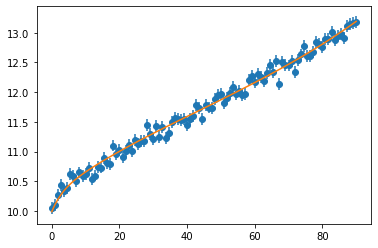

In [25]:
import warnings
from astropy.modeling.fitting import LevMarLSQFitter

def fitHG(mag, magSigma, phaseAngle, tdist, rdist):
    # Description of the (H, G) system:
    #    https://www.britastro.org/asteroids/dymock4.pdf
    nobsv = len(mag)

    # correct the mag to 1AU distance
    dmag = -5. * np.log10(tdist*rdist)
    mag = mag + dmag
    phaseAngle = np.deg2rad(phaseAngle)
    wt = 1./magSigma

    # fit
    fitter = LevMarLSQFitter()
    obs = dict(
        alpha=phaseAngle,
        r=mag*0 + 1,
        mag=mag
        )
    # astropy emits a console warning every time the fitter fails (annoying)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = HG.from_obs(obs, fitter, weights=wt)

    # extract the covariance matrix
    fi = fitter.fit_info
    if 1 <= fi['ierr'] <= 4:
        # fit succeeded
        cov = fi['param_cov']
        sigmaH, sigmaG, covHG = np.sqrt(cov[0,0]), np.sqrt(cov[1,1]), cov[0,1]

        # calculate chi^2/dof
        _mag = HG.evaluate(phaseAngle, res.H.value, res.G.value)
        chi2dof = np.sum(((mag - _mag)*wt)**2.) / (nobsv-len(res.parameters))
        
        return res.H.value, res.G.value, sigmaH, sigmaG, covHG, chi2dof, nobsv
    else:
        # fit failed
        return (np.nan,) * 6 + (0,)
    
# Test of magnitude fitting

from sbpy.photometry import HG
ph = np.linspace(0, 90, 100)
mag = HG.evaluate(np.deg2rad(ph), 10, 0.14)
np.random.seed(42)
sigma = 0.1
mag = np.random.normal(mag, sigma)

H, G, sigmaH, sigmaG, covHG, chi2dof, nobsv = fitHG(mag, sigma, ph, 1., 1.)

plt.scatter(ph, mag)
plt.errorbar(ph, mag, sigma, ls='none')
_ph = sorted(ph)
_mag = HG.evaluate(np.deg2rad(ph), H, G)
plt.plot(_ph, _mag)
print(H, G, f"χ2/dof = {chi2dof}")

Many of the cells below are just for validation/debugging and can be skipped over.

H=18.83±0.00292, G=0.15±0.00381, χ2/dof=0.005
[b'S100uH5sa']


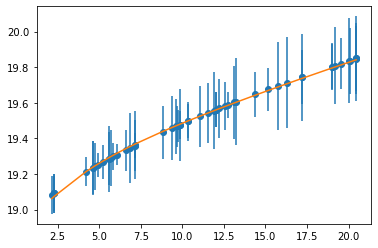

In [26]:
# Test:
# Extract the needed data from the DiaSource and SSSource tables
band = "r".encode("ascii")
_i = splits[5]
obsv = dia[["filter", "mag", "magSigma", "_magTrue", "_name"]][_i]
_sss = sss[["phaseAngle", "topocentricDist", "heliocentricDist"]][_i]

mask = obsv['filter'] == band
obsv = obsv[mask]
_sss = _sss[mask]
mag = obsv["_magTrue"]
#mag = obsv["mag"]
#print(pd.DataFrame(obsv))
#print(pd.DataFrame(_sss))

assert np.all(obsv["filter"] == band)
H, G, sigmaH, sigmaG, covHG, chi2dof, nobsv = \
    fitHG(mag, obsv["magSigma"], _sss["phaseAngle"], _sss["topocentricDist"], _sss["heliocentricDist"])

# plot distance-corrected data
mag1 = mag -5. * np.log10(_sss["topocentricDist"]*_sss["heliocentricDist"])
p = _sss["phaseAngle"]
plt.scatter(p, mag1)
plt.errorbar(p, mag1, obsv["magSigma"], ls='none')

# best-fit overplot
_ph = sorted(p)
_mag = HG.evaluate(np.deg2rad(_ph), H, G)
plt.plot(_ph, _mag)
print(f"H={H:.2f}±{sigmaH:.3}, G={G:.2f}±{sigmaG:.3}, χ2/dof={chi2dof:.3f}")
print(np.unique(obsv["_name"]))

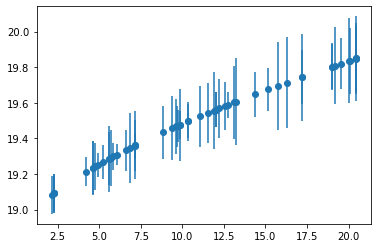

In [27]:
# Test: Verify this is all exact by getting the data from the original files (transformed to CSV)
# use:
#    cd /astro/users/mjuric/projects/github.com/lsst-dm
#    head det/S1_13/visit-0240000.h5.csv -n 1 > S100uH5sa.csv
#    find det/S1_* -name "*.csv" -type f -print0 | parallel -0 grep S100uH5sa | tee -a S100uH5sa.csv
# to generate.

df = pd.read_csv("S100uH5sa.csv")
df = df[df["filter"] == "r"]

# plot distance-corrected data
import astropy.units as u
au = (u.AU).to(u.km)
tx = (df["Ast-Sun(J2000x)(km)"].values - df["Obs-Sun(J2000x)(km)"].values) / au
ty = (df["Ast-Sun(J2000y)(km)"].values - df["Obs-Sun(J2000y)(km)"].values) / au
tz = (df["Ast-Sun(J2000z)(km)"].values - df["Obs-Sun(J2000z)(km)"].values) / au
tdist = np.sqrt(tx**2 + ty**2 + tz**2)
x = (df["Ast-Sun(J2000x)(km)"].values) / au
y = (df["Ast-Sun(J2000y)(km)"].values) / au
z = (df["Ast-Sun(J2000z)(km)"].values) / au
rdist = np.sqrt(x**2 + y**2 + z**2)

mag1 = df["MaginFilterTrue"] -5. * np.log10(tdist*rdist)
p = df["Sun-Ast-Obs(deg)"]
plt.scatter(p, mag1)
plt.errorbar(p, mag1, df["PhotometricSigma(mag)"], ls='none');

Compute the SSObject table columns:

In [28]:
%%time
def computeSSObjectRecord(args):
    k, i = args
    row = obj[k]
    obsv = dia[i]
    _sss = sss[["phaseAngle", "topocentricDist", "heliocentricDist"]][i]

    phaseAngle, topoDist, helioDist = _sss["phaseAngle"], _sss["topocentricDist"], _sss["heliocentricDist"]
    nobs = len(obsv)

    # just verify we didn't screw up something
    assert len(np.unique(obsv["ssObjectId"])) == 1
    assert np.all(obsv["ssObjectId"] == sss[i]["ssObjectId"])
    assert np.all(topoDist > 0.)

    # Metadata columns
    row["ssObjectId"] = obsv["ssObjectId"][0]
    row["firstObservationDate"] = obsv["midPointTai"].min()
    row["discoverySubmissionDate"] = row["firstObservationDate"] + 7. #FIXME: assume we discover everything 7 days after first obsv
    row["arc"] = obsv["midPointTai"].ptp()
    row["numObs"] = len(obsv)
    
    # FIXME: no comets
    row["maxExtendedness"] = 0.
    row["minExtendedness"] = 0.
    row["medianExtendedness"] = 0.

    # FIXME: implement MOID
    
    # Photometry columns:
    # fit absmag/slope for each band
    for b in ("u", "g", "r", "i", "z", "y"):
        mask = obsv['filter'] == b.encode('ascii')
        
        alpha = phaseAngle[mask]

        # require at least five observations, and a decent span (10deg) of phase angles
        if np.count_nonzero(mask) >= 5 and alpha.ptp() > 10:
            H, G, sigmaH, sigmaG, covHG, chi2dof, ndata = \
                fitHG(obsv["mag"][mask], obsv["magSigma"][mask], alpha, topoDist[mask], helioDist[mask])
        else:
            H, G, sigmaH, sigmaG, covHG, chi2dof = ( np.nan, ) * 6
            ndata = 0

        row[f"{b}H"] = H
        row[f"{b}G12"] = G
        row[f"{b}HErr"] = sigmaH
        row[f"{b}G12Err"] = sigmaG 
        row[f"{b}H_{b}G12_Cov"] = covHG
        row[f"{b}Chi2"] = chi2dof
        row[f"{b}Ndata"] = ndata
        
if False:
    # single-thread
    for k, i in enumerate(splits[:1_0]):
        #print(k)
        computeSSObjectRecord((k, i))
else:
    # multi-processing pool
    from tqdm.notebook import tqdm
    from multiprocessing import Pool
    s = splits#[:100_000]
    with Pool(48) as p:
        for _ in tqdm(p.imap(computeSSObjectRecord, enumerate(s), chunksize=1000), total=len(s)):
            pass

#pd.DataFrame(obj[0:10][["rH", "rHErr", "rG12", "rG12Err", "rH_rG12_Cov", "rChi2", "rNdata"]])
pd.DataFrame(obj[0:10]).head()

  0%|          | 0/10556741 [00:00<?, ?it/s]

CPU times: user 2min 11s, sys: 1min 6s, total: 3min 18s
Wall time: 8min 46s


,ssObjectId,discoverySubmissionDate,firstObservationDate,arc,numObs,MOID,MOIDTrueAnomaly,MOIDEclipticLongitude,MOIDDeltaV,uH,uG12,uHErr,uG12Err,uH_uG12_Cov,uChi2,uNdata,gH,gG12,gHErr,gG12Err,gH_gG12_Cov,gChi2,gNdata,rH,rG12,rHErr,rG12Err,rH_rG12_Cov,rChi2,rNdata,iH,iG12,iHErr,iG12Err,iH_iG12_Cov,iChi2,iNdata,zH,zG12,zHErr,zG12Err,zH_zG12_Cov,zChi2,zNdata,yH,yG12,yHErr,yG12Err,yH_yG12_Cov,yChi2,yNdata,maxExtendedness,minExtendedness,medianExtendedness,flags
0,668135024989,60797.136495,60790.136495,0.000000,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
1,3033569589766,63480.233685,63473.233685,1.975244,3,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
2,3148445770109,59937.159828,59930.159828,2693.060059,3,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
3,3369984299447,60203.374981,60196.374981,2582.777100,107,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20.750439,0.154104,0.036021,0.039886,0.001219,1.075859,18,20.054783,0.117877,0.020110,0.025463,0.000430,1.056950,37,19.899048,0.186285,0.033757,0.044007,0.001307,1.225943,31,20.0149,0.181077,0.098879,0.1137,0.01008,1.977524,13,20.066748,0.345189,0.087608,0.133565,0.010005,0.571543,7,0.0,0.0,0.0,0
4,3643818542061,59917.313961,59910.313961,46.793457,10,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,21.622524,0.612382,0.209119,0.356042,0.073873,0.225229,6,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0


Some timings for the above (all on epyc, with swappiness=10%, O_DIRECT flag):
* An empty imap takes about a ~minute (CPU-limited by the driver process)
* An imap w. just reading the inputs from mmapped arrays is ~6 minutes
* A full run takes ~3 hrs

## Utilities

Mass-convert HDF inputs to CSV files (e.g., for easy inspection and grepping).

In [99]:
def _createToCSV_mapper(fn):
    # load
    try:
        det = pd.read_hdf(fn).reset_index()
    except:
        print("ERROR: ", output)
        return (output, 0)

    # write to CSV
    det.to_csv(fn + ".csv", index=False)
    
    return fn, len(det)

def convertToCSV(inputs):
    import os
    from tqdm.notebook import tqdm

    from multiprocessing import Pool
    with Pool(48) as p:
        outputs = dict(tqdm(
            p.imap(
                _createToCSV_mapper, inputs["filename"].values
            ), total=len(inputs)
        ))

    return outputs

outputs = convertToCSV(inputs)
#outputs = dict([_createToCSV_mapper(inputs["filename"].loc[0])])

print(f"Converted {len(outputs)} files, {sum(outputs.values())} rows.")

  0%|          | 0/3689 [00:00<?, ?it/s]

Converted 3689 files, 1043415800 rows.


## Postgres bulk importer

The code below creates control files for pg_bulkload, so we can directly load the binary tables into the postgres database.

In [328]:
typemap = dict(
    i = "INTEGER",
    u = "INTEGER",
    f = "REAL",
    S = "CHAR"
)

def bulkload_type_for_dtype(dtype, offset=None):
    #
    # Convert dtype to type strings for pg_bulkload .ctl files
    #

    # 'code' will be something like <u8 or |S12
    assert len(dtype.descr) == 1
    _, code = dtype.descr[0]
    dbtype = typemap[code[1]]
    size = code[2:]
    if offset is not None:
        offset = f"{offset+1}+"
    else:
        offset = ''

    # Hack to recognize NaN as NULLs
    if dbtype == 'REAL':
        if size == "4":
            nullif = " NULLIF 0000c07f"
        else:
            nullif = " NULLIF 000000000000f87f"
    else:
        nullif = ""

    return f"{dbtype}({offset}{size}){nullif}"


def pgsql_type_for_dtype(dtype, offset=None):
    #
    # Convert dtype to type strings for Postgres' CREATE TABLE
    # FIXME: Postgres doesn't have unsigned ints. What should
    #        we do?
    #
    
    # 'code' will be something like <u8 or |S12
    assert len(dtype.descr) == 1
    _, code = dtype.descr[0]
    size = int(code[2:])
    
    if code[1] in ['i', 'u']:
        dbtype = "int"+str(size)
    elif code[1] == 'f':
        dbtype = "real" if size == 4 else "double precision"
    elif code[1] == "S":
        dbtype = f"CHAR({size})"
    else:
        assert False, f"Unknown datatype {dtype}"

    return dbtype

def gen_create_table_sql(tableName, dtype):
    sql = []
    sql.append(f"drop table if exists {tableName};")
    sql.append(f"create table {tableName} (")
    # pg_bulkload config file text
    flds = []
    for name, field in dtype.fields.items():
        dbtype = pgsql_type_for_dtype(field[0])
        flds.append(f"    {name} {dbtype}")
    sql.append(",\n".join(flds))
    sql.append(")")
    return '\n'.join(sql)

def gen_pg_bulkload_ctl(inputFn, tableName, dtype, limit=10):
    # convert inputFn to absolute
    ctl=[]
    ctl.append(f"INPUT = {inputFn}")
    ctl.append("TYPE = BINARY")
    if limit is not None:
        ctl.append(f"LIMIT = {limit}")
    ctl.append(f"OUTPUT = {tableName}")
    ctl.append("WRITER = DIRECT")

    # pg_bulkload config file text
    for name, field in dtype.fields.items():
        offset = field[1]
        dbtype = bulkload_type_for_dtype(field[0], offset)
        ctl.append(f"COL = {dbtype}")

    return '\n'.join(ctl)

def bulkload(dbname, tableName, inputFn, arr, limit=10):
    dtype = arr.dtype
    
    sqlFn = f"outputs/{tableName}.sql"
    ctlFn = f"outputs/{tableName}.ctl"

    with open(sqlFn, "w") as fp:
        print(gen_create_table_sql(tableName, dtype), file=fp)

    with open(ctlFn, "w") as fp:
        print(gen_pg_bulkload_ctl(inputFn, tableName, dtype, limit=limit), file=fp)

    print(f"sudo -u postgres psql -f {sqlFn} {dbname}")
    print(f"sudo -u postgres time /usr/pgsql-13/bin/pg_bulkload -d {dbname} {ctlFn}")
    print(f"sudo -u postgres psql {dbname} -c 'select * from {tableName} limit 5'")

bulkload("lsst_solsys", "mpc2", "../outputs/mpcorb.npy", mpc, limit=None)
#bulkload("lsst_solsys", "ssObjects", "../outputs/ssObject.npy", obj, limit=None)
#bulkload("lsst_solsys", "diaSources", "../outputs/diaSource.npy", dia, limit=None)
#bulkload("lsst_solsys", "ssSources", "../outputs/ssSource.npy", sss, limit=None)

sudo -u postgres psql -f outputs/mpc2.sql lsst_solsys
sudo -u postgres time /usr/pgsql-13/bin/pg_bulkload -d lsst_solsys outputs/mpc2.ctl
sudo -u postgres psql lsst_solsys -c 'select * from mpc2 limit 5'


```
# Code to build indices; run this manually after import

# performance: https://www.cybertec-postgresql.com/en/postgresql-parallel-create-index-for-better-performance/

SHOW maintenance_work_mem;
SHOW max_parallel_workers;
SHOW max_parallel_maintenance_workers;

SET maintenance_work_mem TO '40 GB';
SET max_parallel_maintenance_workers TO 10;

ALTER TABLE mpcorb SET (parallel_workers = 32);
alter table mpcorb add primary key (mpcdesignation);
create unique index ON mpcorb(ssObjectId);
create unique index ON mpcorb(mpcDesignation);
create index ON mpcorb(q);
create index ON mpcorb(e);
create index ON mpcorb(incl);
create index ON mpcorb(mpcH);

ALTER TABLE ssObjects SET (parallel_workers = 32);
create unique index ON ssObjects(ssObjectId);
create index ON ssObjects(numObs);
create index ON ssObjects(arc);

ALTER TABLE diaSources SET (parallel_workers = 32);
create unique index ON diaSources(diaSourceId);
create index ON diaSources(ssObjectId);
create index ON diaSources(midPointTai);
create index ON diaSources(ccdVisitId);
create index ON diaSources(ra);
create index ON diaSources(decl);
create index ON diaSources(filter);

ALTER TABLE ssSources SET (parallel_workers = 32);
create unique index ON ssSources(diaSourceId);
create index ON ssSources(ssObjectId);
create index ON ssSources(eclipticLambda);
create index ON ssSources(eclipticBeta);
```

```
CREATE USER sssc WITH PASSWORD --quoted-password-here--;
GRANT CONNECT ON DATABASE lsst_solsys TO sssc;
GRANT USAGE ON SCHEMA public TO sssc;
GRANT SELECT ON ALL TABLES IN SCHEMA public TO sssc;
ALTER DEFAULT PRIVILEGES IN SCHEMA public GRANT SELECT ON TABLES TO sssc;
```

Use this to disconnect connected users when needed (e.g., to import new versions of tables).

```sql
SELECT pid, username
FROM pg_stat_activity
WHERE pg_stat_activity.datname = 'lsst_solsys' -- ← change this to your DB
  AND pid <> pg_backend_pid();
```

Below are scraps from debugging...

In [159]:
pd.DataFrame(mpc[:5])

,mpcDesignation,mpcNumber,ssObjectId,mpcH,mpcG,epoch,tperi,peri,node,incl,e,n,q,uncertaintyParameter,reference,nobs,nopp,arc,arcStart,arcEnd,rms,pertsShort,pertsLong,computer,flags,fullDesignation,lastIncludedObservation
0,b'SR000001a',0,15788168397775243006,7.95,0.15,54800.0,52354.06796,47.02487,66.70177,0.0,0.56904,0.0,7.88721,b'',b'',0,0,0.0,0.0,0.0,0.0,b'',b'',b'',0,b'',0.0
1,b'SR000002a',0,1638696702905544284,11.90,0.15,54800.0,54255.95952,111.14332,149.76906,0.0,0.07272,0.0,7.90048,b'',b'',0,0,0.0,0.0,0.0,0.0,b'',b'',b'',0,b'',0.0
2,b'SR000003a',0,12298016463469666278,7.58,0.15,54800.0,32718.27775,86.93460,157.72377,0.0,0.25853,0.0,18.93842,b'',b'',0,0,0.0,0.0,0.0,0.0,b'',b'',b'',0,b'',0.0
3,b'SR000004a',0,2476339031007217136,12.99,0.15,54800.0,49162.23730,357.05184,318.01916,0.0,0.16372,0.0,8.90149,b'',b'',0,0,0.0,0.0,0.0,0.0,b'',b'',b'',0,b'',0.0
4,b'SR000006a',0,12007666665710405350,9.28,0.15,54800.0,-13278.77515,302.03901,292.49508,0.0,0.35683,0.0,14.56498,b'',b'',0,0,0.0,0.0,0.0,0.0,b'',b'',b'',0,b'',0.0


In [151]:
len(dia)

1043415800

In [99]:
int(''.join(reversed(['fe', '06', '71', '2b','82', 'd7', '1a', 'db'])), base=16)

15788168397775243006

In [41]:
mpc.dtype.descr

[('mpcDesignation', '|S16'),
 ('mpcNumber', '<i4'),
 ('ssObjectId', '<u8'),
 ('mpcH', '<f4'),
 ('mpcG', '<f4'),
 ('epoch', '<f8'),
 ('tperi', '<f8'),
 ('peri', '<f8'),
 ('node', '<f8'),
 ('incl', '<f8'),
 ('e', '<f8'),
 ('n', '<f8'),
 ('q', '<f8'),
 ('uncertaintyParameter', '|S1'),
 ('reference', '|S9'),
 ('nobs', '<i4'),
 ('nopp', '<i4'),
 ('arc', '<f4'),
 ('arcStart', '<f8'),
 ('arcEnd', '<f8'),
 ('rms', '<f4'),
 ('pertsShort', '|S3'),
 ('pertsLong', '|S3'),
 ('computer', '|S10'),
 ('flags', '<i4'),
 ('fullDesignation', '|S26'),
 ('lastIncludedObservation', '<f4')]

In [101]:
mpc[0]

(b'SR000001a', 42, 15788168397775243006, 7.95, 0.15, 54800., 52354.06796, 47.02487, 66.70177, 0., 0.56904, 0., 7.88721, b'', b'', 0, 0, 0., 0., 0., 0., b'', b'', b'', 0, b'', 0.)

In [103]:
hex(10752)

'0x2a00'

In [109]:
int(''.join(reversed(['00', '00', '00', '00',])), base=16)

0

In [110]:
mpc[0]["mpcNumber"] = int(''.join(reversed(['00', '00', '00', '00',])), base=16)